In [54]:
# ------------------ IMPORTAR LIBRERÍAS ------------------
import requests
import pandas as pd
import numpy as np
import missingno as msno
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis


# Configuración de gráficos
sns.set(style="whitegrid")


# ------------------ 1️⃣ EXTRACCIÓN DE DATOS DESDE LA API ------------------


API_URL = "https://ratings.food.gov.uk/api/open-data-files/FHRS529en-GB.json"
response = requests.get(API_URL)


if response.status_code == 200:
    hygiene_data = response.json()
    print("Datos obtenidos correctamente.")
else:
    print(f" Error en la solicitud: {response.status_code}")
    exit()

Datos obtenidos correctamente.


In [55]:
# ------------------ 2️⃣ MANEJO DE LA ESTRUCTURA DEL JSON ------------------

# Extraer la lista de establecimientos
if "FHRSEstablishment" in hygiene_data and "EstablishmentCollection" in hygiene_data["FHRSEstablishment"]:
    establishments = hygiene_data["FHRSEstablishment"]["EstablishmentCollection"]
    df = pd.DataFrame(establishments)
    print(" DataFrame creado con éxito.")
else:
    print(" No se encontraron datos en la API.")
    exit()

 DataFrame creado con éxito.


In [56]:
# ------------------ 3️⃣ DESCRIPCIÓN DEL DATASET ------------------
print("Información general del dataset:")
print(df.info())


print("Primeras 10 filas:")
print(df.head(10))


print("Estadísticas descriptivas:")
print(df.describe(include="all"))

Información general del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1298 entries, 0 to 1297
Data columns (total 21 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   FHRSID                      1298 non-null   int64 
 1   LocalAuthorityBusinessID    1298 non-null   object
 2   BusinessName                1298 non-null   object
 3   BusinessType                1298 non-null   object
 4   BusinessTypeID              1298 non-null   int64 
 5   RatingValue                 1298 non-null   object
 6   RatingKey                   1298 non-null   object
 7   RatingDate                  1120 non-null   object
 8   LocalAuthorityCode          1298 non-null   object
 9   LocalAuthorityName          1298 non-null   object
 10  LocalAuthorityWebSite       1298 non-null   object
 11  LocalAuthorityEmailAddress  1298 non-null   object
 12  Scores                      1071 non-null   object
 13  SchemeType     

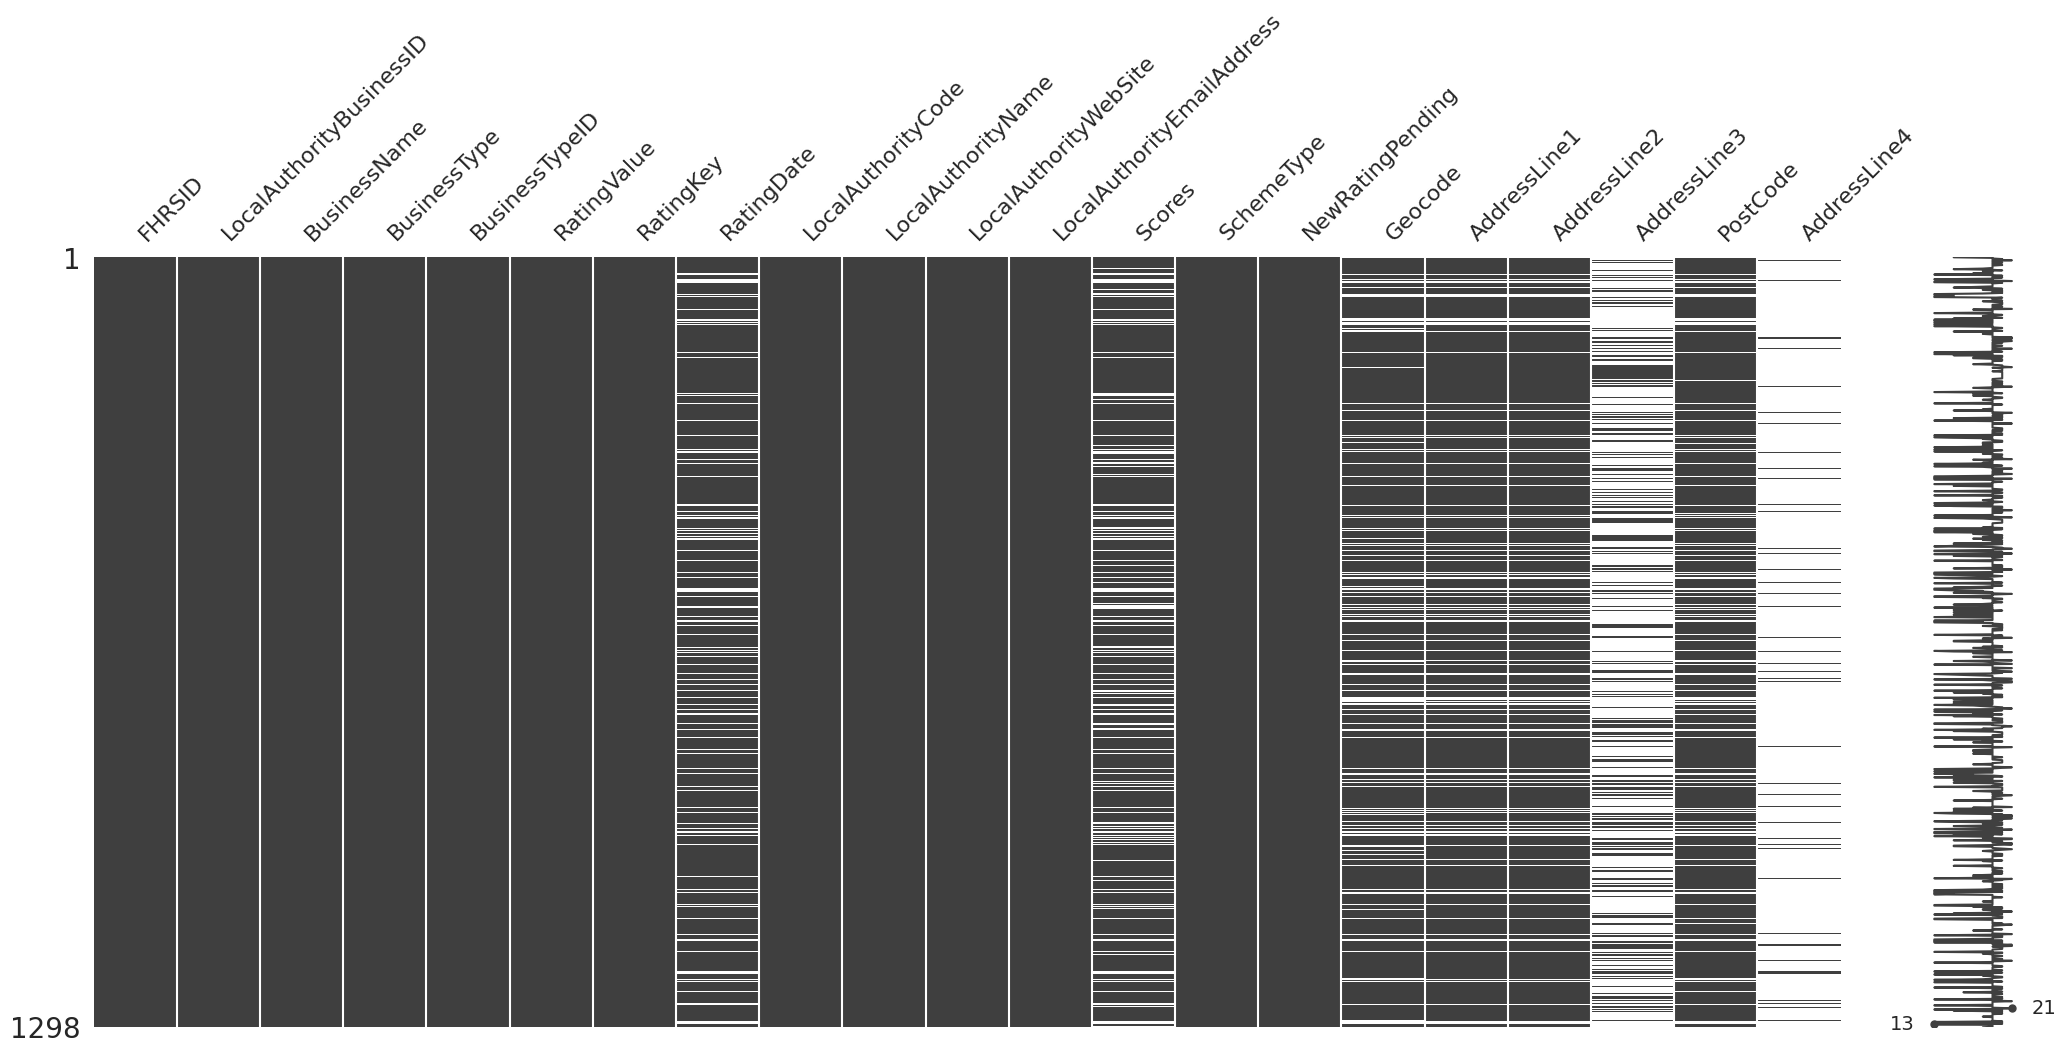


 Dataset limpio. Número de filas después de eliminar nulos: 985
<class 'pandas.core.frame.DataFrame'>
Index: 985 entries, 2 to 1296
Data columns (total 19 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   FHRSID                      985 non-null    int64 
 1   LocalAuthorityBusinessID    985 non-null    object
 2   BusinessName                985 non-null    object
 3   BusinessType                985 non-null    object
 4   BusinessTypeID              985 non-null    int64 
 5   RatingValue                 985 non-null    object
 6   RatingKey                   985 non-null    object
 7   RatingDate                  985 non-null    object
 8   LocalAuthorityCode          985 non-null    object
 9   LocalAuthorityName          985 non-null    object
 10  LocalAuthorityWebSite       985 non-null    object
 11  LocalAuthorityEmailAddress  985 non-null    object
 12  Scores                      985 non-null    o

In [57]:
# ------------------ 4️⃣ LIMPIEZA DE DATOS ------------------
msno.matrix(df)
plt.show()

# Eliminamos columnas con muchos nulos
for col in ["AddressLine3", "AddressLine4"]:
    if col in df.columns:
        df.drop(col, axis=1, inplace=True)

# Eliminamos solo las filas que tienen nulos en columnas clave
columnas_clave = ["RatingDate", "Scores", "Geocode"]
df.dropna(subset=columnas_clave, inplace=True)

# Verificación final
print(f"\n Dataset limpio. Número de filas después de eliminar nulos: {df.shape[0]}")
print(df.info())

In [58]:
# ------------------ 5️⃣ MANEJO DE DATOS ANIDADOS ------------------

# Extraer las puntuaciones de higiene, estructura y confianza en la gestión
if "Scores" in df.columns:
    scores_df = df["Scores"].apply(pd.Series)
    df = pd.concat([df.drop(columns=["Scores"]), scores_df], axis=1)


# Extraer coordenadas de geolocalización
if "Geocode" in df.columns:
    geo_df = df["Geocode"].apply(pd.Series)
    df = pd.concat([df.drop(columns=["Geocode"]), geo_df], axis=1)


# Reemplazar valores nulos en las nuevas columnas con -1 (para indicar falta de datos)
df.fillna({"Hygiene": -1, "Structural": -1, "ConfidenceInManagement": -1, "Longitude": np.nan, "Latitude": np.nan}, inplace=True)


print("\n Datos después de la transformación:")
print(df.info())


# ------------------ 6️⃣ ENRIQUECIMIENTO DE DATOS ------------------
print("\n Enriqueciendo datos...")
df["RatingDate"] = pd.to_datetime(df["RatingDate"], errors="coerce")  # Convertir a fecha
df["Hygiene_Score_Level"] = df["Hygiene"].apply(lambda x: "Bajo" if x <= 5 else "Alto")  # Categorizar higiene


 Datos después de la transformación:
<class 'pandas.core.frame.DataFrame'>
Index: 985 entries, 2 to 1296
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   FHRSID                      985 non-null    int64 
 1   LocalAuthorityBusinessID    985 non-null    object
 2   BusinessName                985 non-null    object
 3   BusinessType                985 non-null    object
 4   BusinessTypeID              985 non-null    int64 
 5   RatingValue                 985 non-null    object
 6   RatingKey                   985 non-null    object
 7   RatingDate                  985 non-null    object
 8   LocalAuthorityCode          985 non-null    object
 9   LocalAuthorityName          985 non-null    object
 10  LocalAuthorityWebSite       985 non-null    object
 11  LocalAuthorityEmailAddress  985 non-null    object
 12  SchemeType                  985 non-null    object
 13  NewRatingPending

In [59]:
# ------------------ 8️⃣ CONECTAR A BASE DE DATOS SQL ------------------


conn = sqlite3.connect("hygiene_ratings.sqlite")
df.to_sql("hygiene_ratings", conn, index=False, if_exists="replace")
print(" Datos guardados en SQLite.")


# ------------------ 9️⃣ CONSULTAS SQL ------------------
def execute_and_display(query, conn, description):
    print(f"\n {description}")
    cursor = conn.cursor()
    cursor.execute(query)
    results = cursor.fetchall()
    columns = [desc[0] for desc in cursor.description]


    print(pd.DataFrame(results, columns=columns))


# 1️⃣ Mostrar los primeros 10 establecimientos
query_1 = "SELECT * FROM hygiene_ratings LIMIT 10;"
execute_and_display(query_1, conn, "Primeras 10 filas de la base de datos")


# 2️⃣ Contar el número total de establecimientos
query_2 = "SELECT COUNT(*) AS total_establishments FROM hygiene_ratings;"
execute_and_display(query_2, conn, "Número total de establecimientos")


# 3️⃣ Obtener las 5 peores calificaciones de higiene
query_3 = """
SELECT BusinessName, RatingValue, Hygiene
FROM hygiene_ratings
WHERE Hygiene >= 0
ORDER BY Hygiene DESC
LIMIT 5;
"""
execute_and_display(query_3, conn, "Establecimientos con peor higiene")


# 4️⃣ Obtener las 5 mejores calificaciones de higiene
query_4 = """
SELECT BusinessName, RatingValue, Hygiene
FROM hygiene_ratings
WHERE Hygiene >= 0
ORDER BY Hygiene ASC
LIMIT 5;
"""
execute_and_display(query_4, conn, "Establecimientos con mejor higiene")


# Cerrar la conexión
conn.close()
print("\n Conexión cerrada. ¡Análisis completo!")




# Asegurar que la columna "Hygiene" existe y no tiene valores nulos
df_numeric = df[["Hygiene"]].dropna()


 Datos guardados en SQLite.

 Primeras 10 filas de la base de datos
    FHRSID LocalAuthorityBusinessID                          BusinessName  \
0  1634041             23/00265/COM                  3B Convenience Store   
1   898515             06/00098/COM                A - Z Afterschool Club   
2  1080769             18/00246/COM                   A And J Mini Market   
3  1419391             21/00426/COM           A To Z Fresh Sutton Limited   
4   632116         06625/0082/2/000                            Abbeyfield   
5   553481         06952/0082/2/000                            Abbeyfield   
6  1038629             18/00077/COM                 ABI Convenience Store   
7  1624010             23/00207/COM  ABM Catering @ Overton Grange School   
8  1644558             23/00308/COM                      Achieve Together   
9   571001         06329/0031/0/000     Achieve Together - 31 Egmont Road   

                          BusinessType  BusinessTypeID RatingValue  \
0             

<ipython-input-60-49369a020664>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df["RatingValue"], order=df["RatingValue"].value_counts().index, palette="coolwarm")


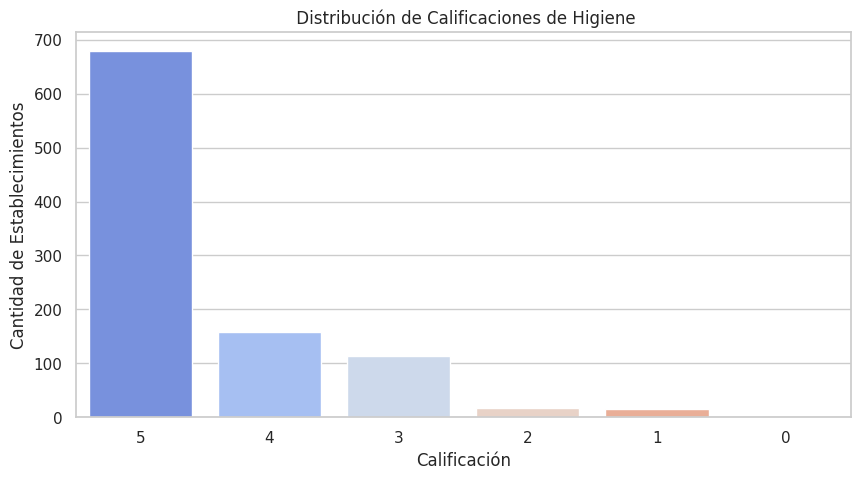

<ipython-input-60-49369a020664>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df["BusinessType"].value_counts().head(10).index,


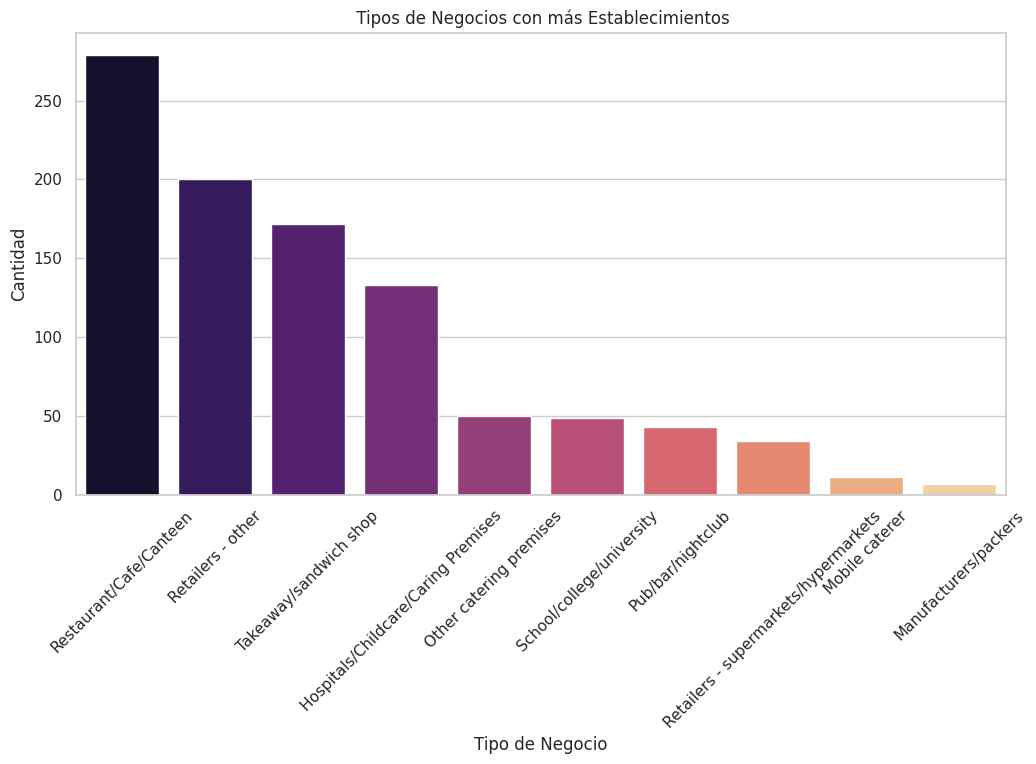

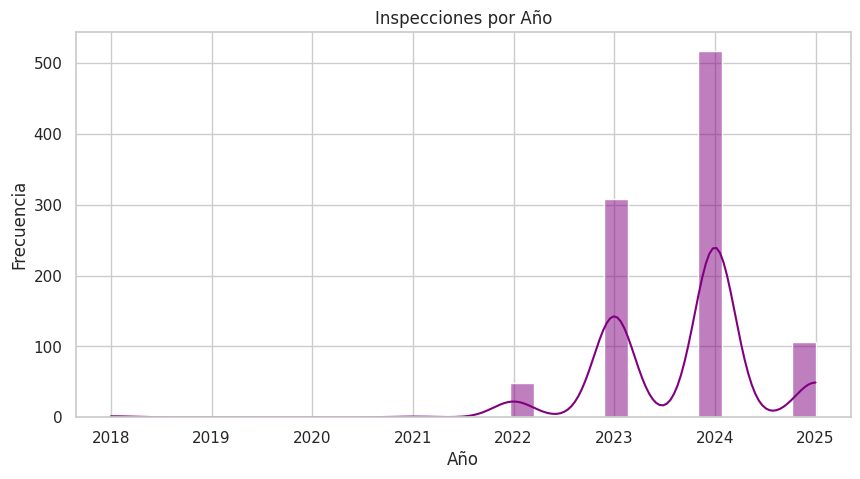

<ipython-input-60-49369a020664>:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Hygiene_Score_Level", y=df["Hygiene"], data=df, palette="Set2")


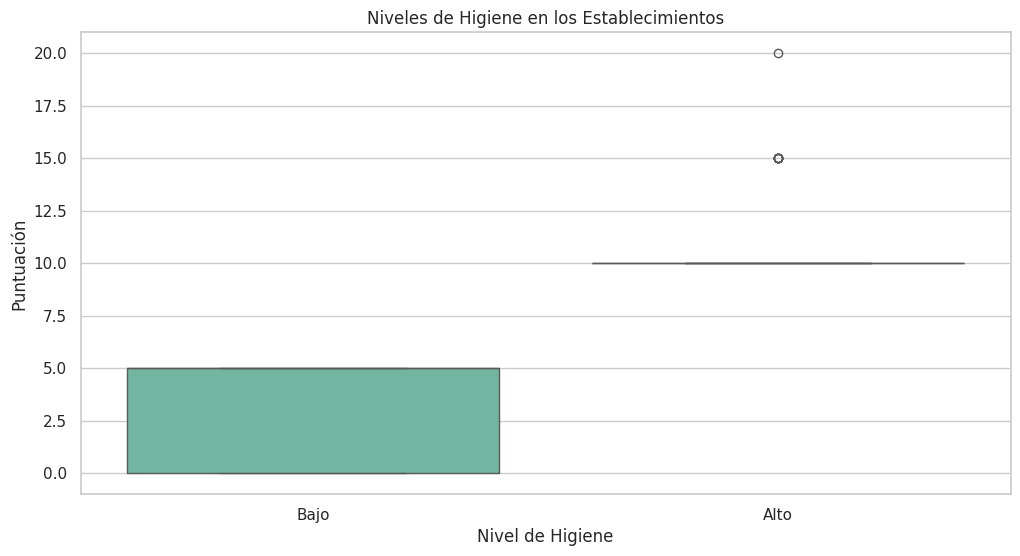

In [60]:
# ------------------ 7️⃣ DATA STORYTELLING ------------------


### 1️⃣ Pregunta: ¿Cuál es la distribución de calificaciones de higiene?
plt.figure(figsize=(10, 5))
sns.countplot(x=df["RatingValue"], order=df["RatingValue"].value_counts().index, palette="coolwarm")
plt.title(" Distribución de Calificaciones de Higiene")
plt.xlabel("Calificación")
plt.ylabel("Cantidad de Establecimientos")
plt.show()


### 2️⃣ Pregunta: ¿Cuál es la distribución de tipos de negocios?
plt.figure(figsize=(12, 6))
sns.barplot(x=df["BusinessType"].value_counts().head(10).index,
            y=df["BusinessType"].value_counts().head(10).values, palette="magma")
plt.title(" Tipos de Negocios con más Establecimientos")
plt.xlabel("Tipo de Negocio")
plt.ylabel("Cantidad")
plt.xticks(rotation=45)
plt.show()


### 3️⃣ Pregunta: ¿Cómo ha evolucionado la cantidad de inspecciones por año?
plt.figure(figsize=(10, 5))
sns.histplot(df["RatingDate"].dt.year.dropna(), bins=30, kde=True, color="purple")
plt.title("Inspecciones por Año")
plt.xlabel("Año")
plt.ylabel("Frecuencia")
plt.show()


### 4️⃣ Pregunta: ¿Cuáles son las peores y mejores puntuaciones de higiene?
plt.figure(figsize=(12, 6))
sns.boxplot(x="Hygiene_Score_Level", y=df["Hygiene"], data=df, palette="Set2")
plt.title("Niveles de Higiene en los Establecimientos")
plt.xlabel("Nivel de Higiene")
plt.ylabel("Puntuación")
plt.show()



 Análisis Univariado de la Higiene

Media: 4.31
Mediana: 5.00
Moda: 5.00
Varianza: 11.45
Desviación Estándar: 3.38
Rango Intercuartílico (IQR): 5.00
Q1 (25%): 0.00
Q2 (Mediana, 50%): 5.00
Q3 (75%): 5.00
Percentil 90: 10.00
Asimetría: 0.39
Curtosis: 0.10


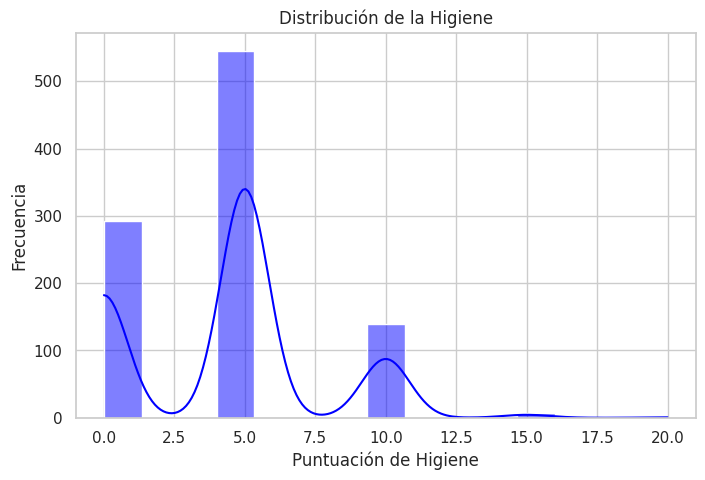

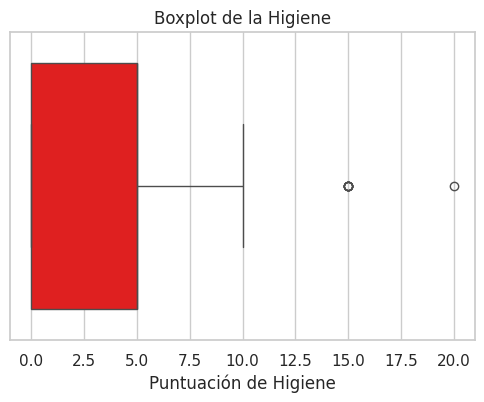

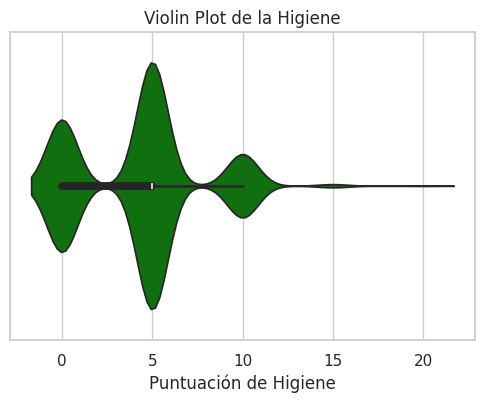

In [61]:
# ------------------ ANÁLISIS UNIVARIADO ------------------


# Calcular estadísticas
analysis_results = {
    "Media": df_numeric["Hygiene"].mean(),
    "Mediana": df_numeric["Hygiene"].median(),
    "Moda": df_numeric["Hygiene"].mode().iloc[0] if not df_numeric["Hygiene"].mode().empty else np.nan,
    "Varianza": df_numeric["Hygiene"].var(),
    "Desviación Estándar": df_numeric["Hygiene"].std(),
    "Rango Intercuartílico (IQR)": df_numeric["Hygiene"].quantile(0.75) - df_numeric["Hygiene"].quantile(0.25),
    "Q1 (25%)": df_numeric["Hygiene"].quantile(0.25),
    "Q2 (Mediana, 50%)": df_numeric["Hygiene"].quantile(0.50),
    "Q3 (75%)": df_numeric["Hygiene"].quantile(0.75),
    "Percentil 90": df_numeric["Hygiene"].quantile(0.90),
    "Asimetría": skew(df_numeric["Hygiene"]),
    "Curtosis": kurtosis(df_numeric["Hygiene"])
}


# Convertir los resultados en un DataFrame para visualización
analysis_df = pd.DataFrame.from_dict(analysis_results, orient='index', columns=["Valor"])

# Imprimir los resultados en formato tabla
print("\n Análisis Univariado de la Higiene\n")
for key, value in analysis_results.items():
    print(f"{key}: {value:.2f}")

# ------------------ VISUALIZACIONES ------------------


# Histograma
plt.figure(figsize=(8, 5))
sns.histplot(df_numeric["Hygiene"], bins=15, kde=True, color="blue")
plt.title("Distribución de la Higiene")
plt.xlabel("Puntuación de Higiene")
plt.ylabel("Frecuencia")
plt.show()


# Boxplot
plt.figure(figsize=(6, 4))
sns.boxplot(x=df_numeric["Hygiene"], color="red")
plt.title("Boxplot de la Higiene")
plt.xlabel("Puntuación de Higiene")
plt.show()


# Violin Plot
plt.figure(figsize=(6, 4))
sns.violinplot(x=df_numeric["Hygiene"], color="green")
plt.title("Violin Plot de la Higiene")
plt.xlabel("Puntuación de Higiene")
plt.show()


 Análisis Bivaariado



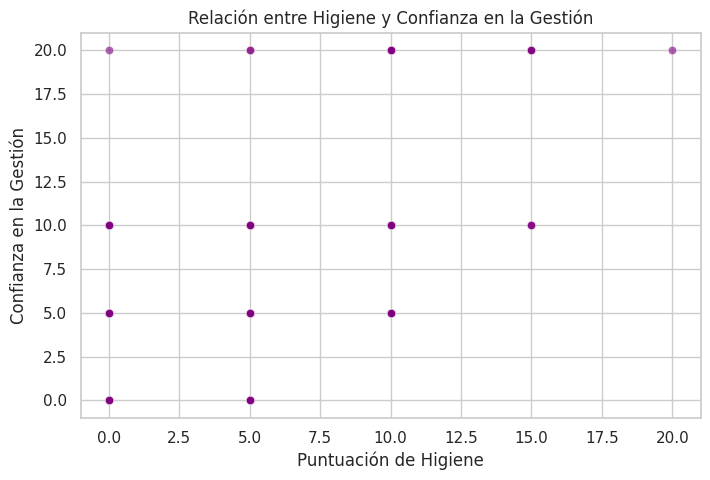

<ipython-input-62-b2ef92d89689>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="BusinessType", y="Hygiene", data=df_filtered, palette="Set3")


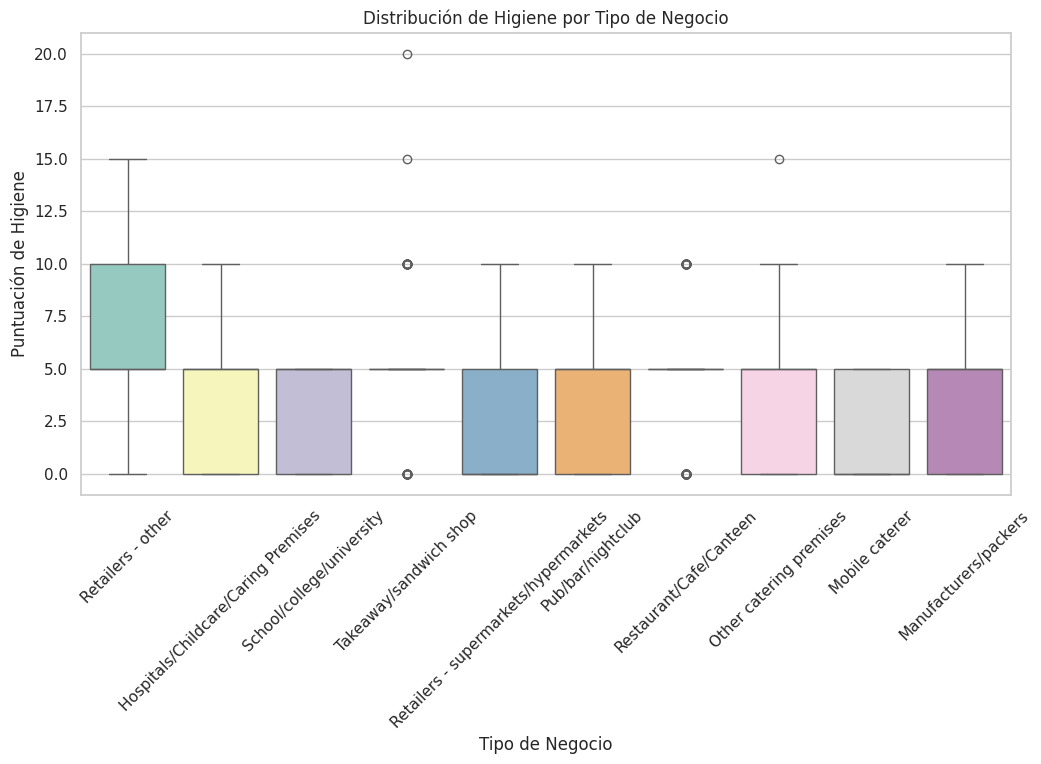

In [62]:
# ------------------ ANÁLISIS BIVARIADO ------------------
# Seleccionar solo las columnas numéricas relevantes
df_numeric = df[["Hygiene", "ConfidenceInManagement", "Structural"]].dropna()
print("\n Análisis Bivaariado\n")

# 1️⃣ Gráfico de dispersión: Relación entre Higiene y Confianza en la Gestión
plt.figure(figsize=(8, 5))
sns.scatterplot(x=df_numeric["Hygiene"], y=df_numeric["ConfidenceInManagement"], alpha=0.6, color="purple")
plt.title("Relación entre Higiene y Confianza en la Gestión")
plt.xlabel("Puntuación de Higiene")
plt.ylabel("Confianza en la Gestión")
plt.show()

# 2️⃣ Boxplot: Comparación de Higiene por Tipo de Negocio
plt.figure(figsize=(12, 6))
top_business_types = df["BusinessType"].value_counts().index[:10]  # Seleccionar los 10 tipos de negocio más comunes
df_filtered = df[df["BusinessType"].isin(top_business_types)]  # Filtrar solo esos tipos de negocio

sns.boxplot(x="BusinessType", y="Hygiene", data=df_filtered, palette="Set3")
plt.xticks(rotation=45)
plt.title("Distribución de Higiene por Tipo de Negocio")
plt.xlabel("Tipo de Negocio")
plt.ylabel("Puntuación de Higiene")
plt.show()



 Análisis Multivariado



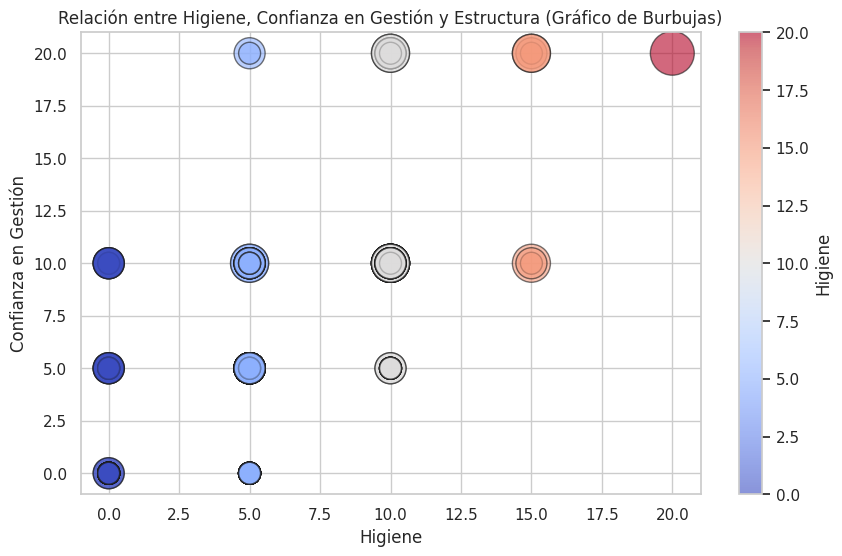

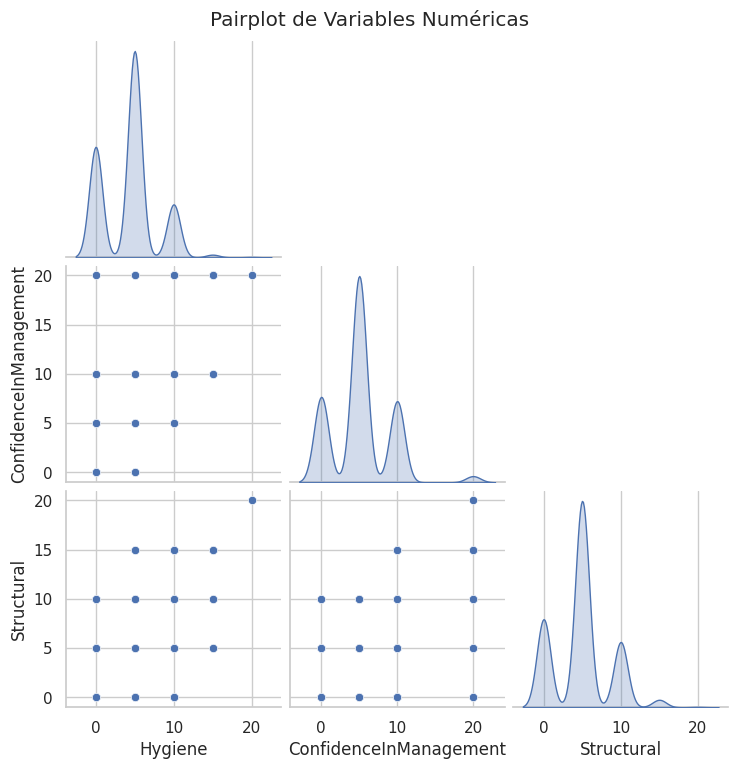

<Figure size 1000x500 with 0 Axes>

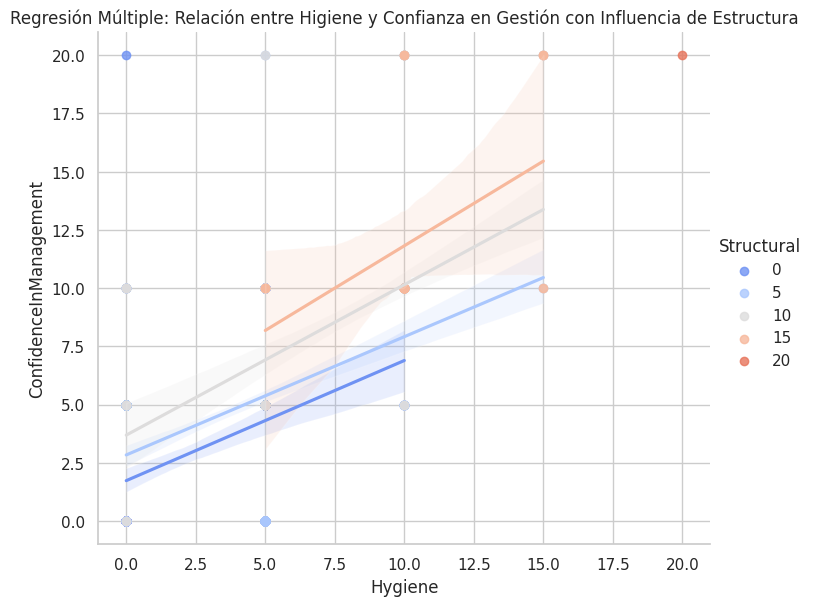

In [63]:
# ------------------ ANÁLISIS MULTIVARIADO ------------------
# Seleccionar columnas numéricas relevantes
df_numeric = df[["Hygiene", "ConfidenceInManagement", "Structural"]].dropna()
print("\n Análisis Multivariado\n")

# 1️⃣ **Gráfico de Burbujas: Higiene, Confianza en la Gestión y Estructura**
plt.figure(figsize=(10, 6))
plt.scatter(df_numeric["Hygiene"], df_numeric["ConfidenceInManagement"],
            s=df_numeric["Structural"] * 50,
            alpha=0.6, c=df_numeric["Hygiene"], cmap="coolwarm", edgecolors="k")
plt.xlabel("Higiene")
plt.ylabel("Confianza en Gestión")
plt.title("Relación entre Higiene, Confianza en Gestión y Estructura (Gráfico de Burbujas)")
plt.colorbar(label="Higiene")
plt.grid(True)
plt.show()


# 2️⃣ **Pairplot de las Variables Numéricas**
sns.pairplot(df_numeric, diag_kind="kde", corner=True)
plt.suptitle("Pairplot de Variables Numéricas", y=1.02)
plt.show()


# 3️⃣ **Regresión Múltiple: Higiene vs Confianza y Estructura**
plt.figure(figsize=(10, 5))
sns.lmplot(x="Hygiene", y="ConfidenceInManagement", hue="Structural", data=df_numeric, palette="coolwarm", height=6, aspect=1.2)
plt.title("Regresión Múltiple: Relación entre Higiene y Confianza en Gestión con Influencia de Estructura")
plt.show()
